In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.table import Table
plt.style.use('sra_style.mplstyle')


##
r_star = 0.805* const.R_sun
r_planet = 1.21*const.R_jup
transit_depth_fraction = (r_planet**2 / r_star**2).decompose()
print(transit_depth_fraction)

##

mag_error = 0.005
transit_depth = 2.5*np.log10(1 + transit_depth_fraction)
print(transit_depth)

data = np.hstack([np.random.normal(loc=1, scale=mag_error, size=30), 
                  np.random.normal(loc=1+transit_depth, scale=mag_error, size=40), 
                  np.random.normal(loc=1, scale=mag_error, size=30)])

data_table = Table({'mag': data, 'mag_error': mag_error*np.ones_like(data), 'time': np.arange(100)})
print(data_table)

0.023858869765539862
0.025600242414574682
       mag         mag_error time
------------------ --------- ----
1.0053177967587796     0.005    0
1.0033727593750683     0.005    1
0.9998389297881272     0.005    2
1.0009711886893073     0.005    3
1.0098622912130986     0.005    4
0.9900925254478492     0.005    5
1.0018072902255746     0.005    6
0.9973961121517578     0.005    7
1.0009248537174447     0.005    8
0.9985847029921772     0.005    9
               ...       ...  ...
0.9947620967816377     0.005   89
1.0023034727348858     0.005   90
0.9992140345416597     0.005   91
0.9974860926527713     0.005   92
0.9960811491870794     0.005   93
1.0033987231732222     0.005   94
1.0004779289345405     0.005   95
1.0008434658791328     0.005   96
1.0009641413866384     0.005   97
1.0106056993553427     0.005   98
1.0077684213424636     0.005   99
Length = 100 rows


Here we have data from an unknown transit. By eye, the transit depth appears to be about 0.02 or 0.03 mag (2 or 3 milli mag). But lets calculate it rigorously from the data. We want to make sure the answer is between 2 and 3.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


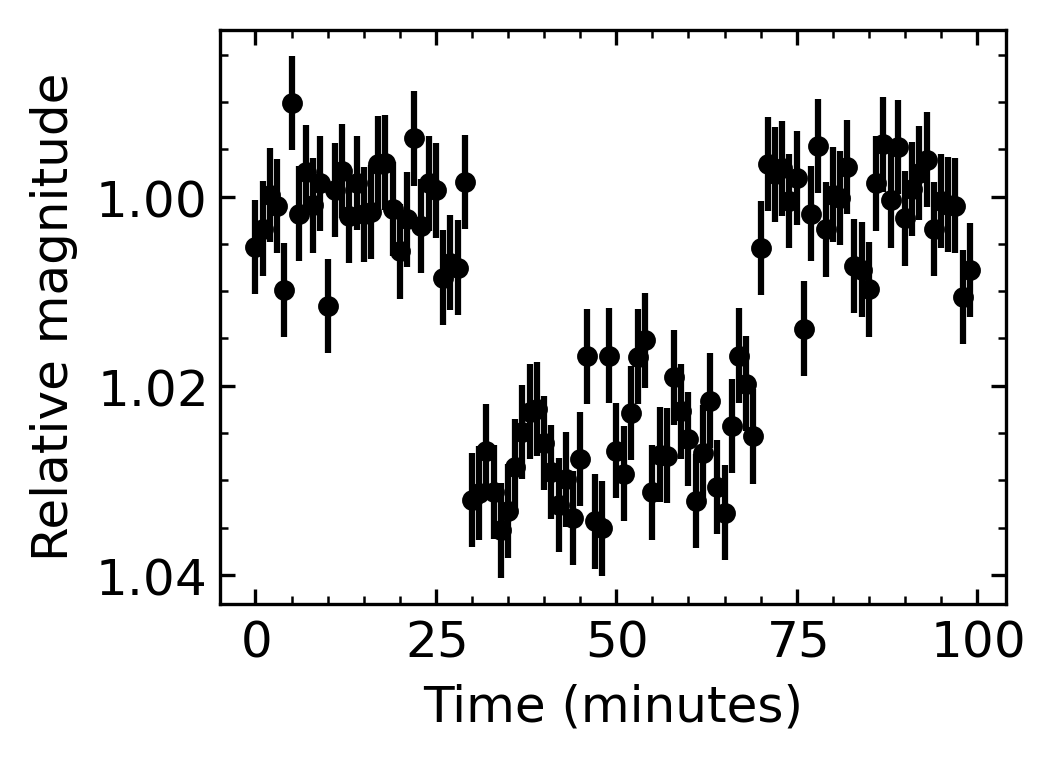

In [2]:
plt.figure()
plt.errorbar(data_table['time'], data_table['mag'], yerr=data_table['mag_error'], ls='none', color='k')
plt.scatter(data_table['time'], data_table['mag'], marker='o', color='k')
plt.xlabel('Time (minutes)')
plt.ylabel('Relative magnitude')
plt.gca().invert_yaxis()
plt.show()

To do that, we are going to do the following:
1. calculate the average value out of transit and in transit
2. subtract the two. That is the transit depth.
3. Then we are going to calculate the error in the transit depth.

Lets do 1. first.

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


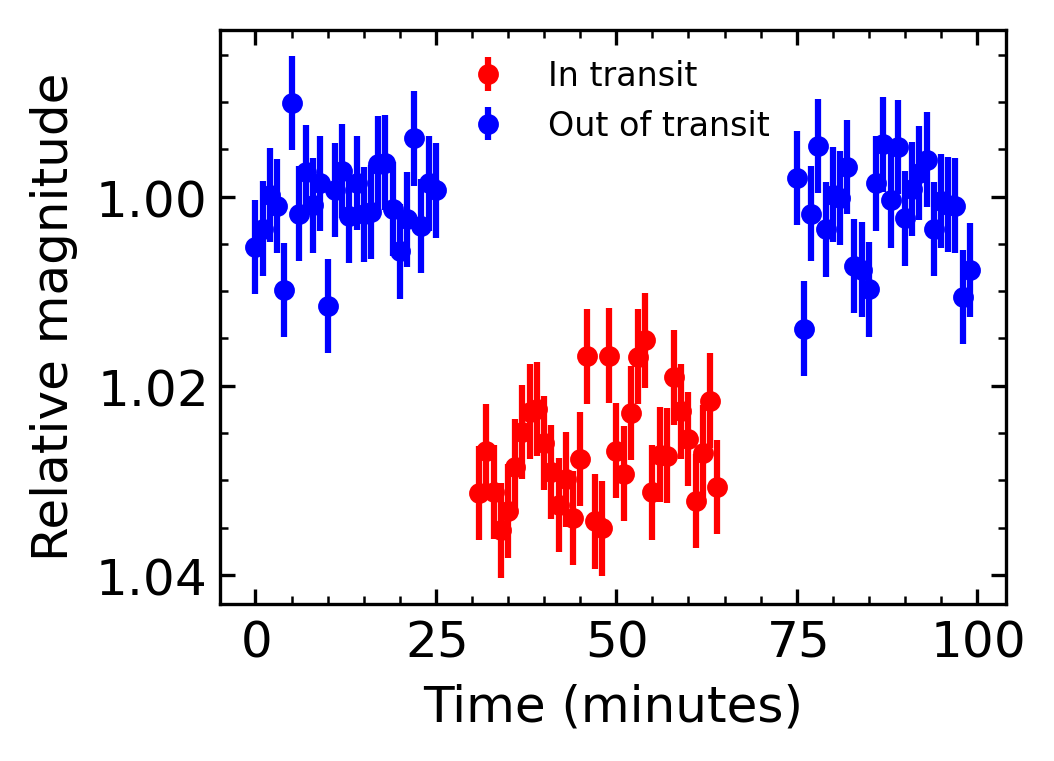

(None,)

In [3]:

# section out the data based on time
in_transit = np.logical_and(data_table['time'] < 65, data_table['time'] > 30)
out_of_transit = ~np.logical_and(data_table['time'] < 75, data_table['time'] > 25)

data_in_transit = data_table[in_transit]
data_out_of_transit = data_table[out_of_transit]
###


plt.figure()
plt.errorbar(data_in_transit['time'], data_in_transit['mag'], yerr=data_in_transit['mag_error'], 
             ls='none', marker='o', color='r', label='In transit')
plt.errorbar(data_out_of_transit['time'], data_out_of_transit['mag'], yerr=data_out_of_transit['mag_error'], 
             ls='none', marker='o', color='b', label='Out of transit')
plt.xlabel('Time (minutes)')
plt.ylabel('Relative magnitude')
plt.gca().invert_yaxis()
plt.legend(loc='best')
plt.show(),

So now we are going to find the average level of the red data, and the average level of the blue data.

You can do this formally with python and curve fitting, https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

but it is actually easy enough to calculate it on your own with python.
The formula for the average magnitude $m$, and the error on that measurement $m_i$ is

$$
m = \frac{\sum_i \frac{m_i}{\sigma_i^2}}{\sum_k \frac{1}{\sigma_k^2} }
$$

And the uncertainty in the estimate of that level $m$ is 

$$
\sigma_{m}^2 = \frac{1}{\sum_k \frac{1}{\sigma_k^2}}
$$

In [4]:
def mean_and_error(data, error):
    ivar = 1/error**2
    
    average = np.sum(data*ivar)/np.sum(ivar)
    error_estimate = np.sqrt(1/np.sum(ivar))
    return average, error_estimate
    
mag_out_of_transit, err_mag_out_of_transit = mean_and_error(data_out_of_transit['mag'], data_out_of_transit['mag_error'])

mag_in_transit, err_mag_in_transit = mean_and_error(data_in_transit['mag'], data_in_transit['mag_error'])

### Now we plot our transit depths and mags to make sure they make sense.

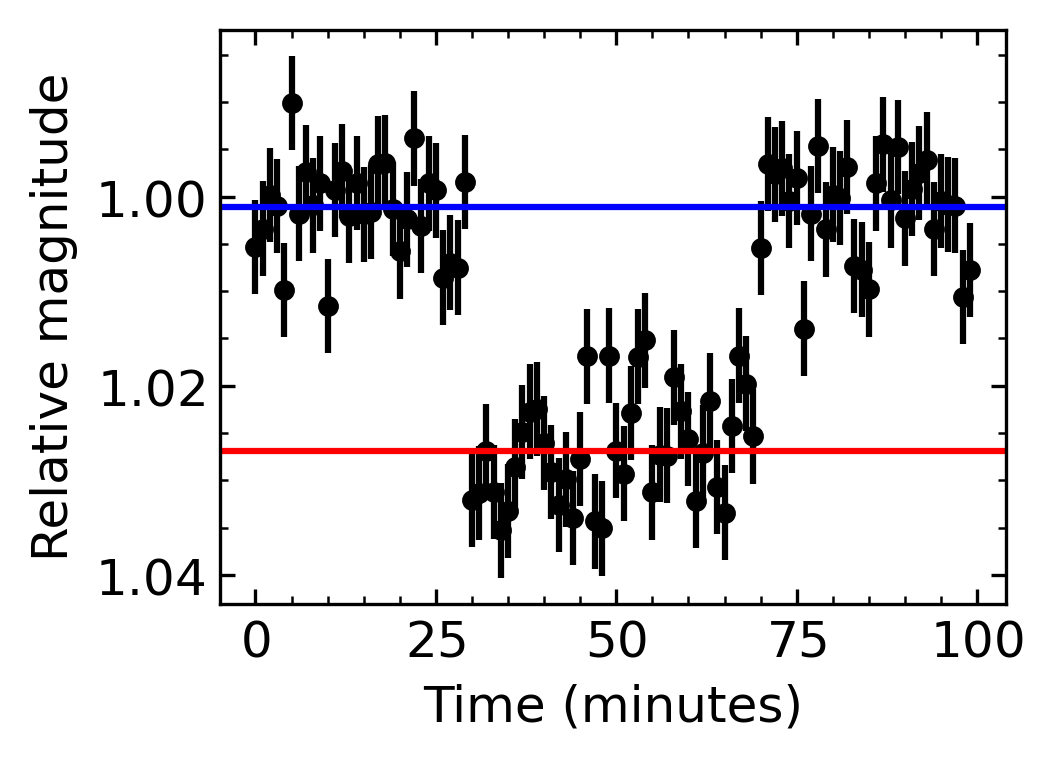

In [5]:
plt.figure()
plt.errorbar(data_table['time'], data_table['mag'], yerr=data_table['mag_error'], ls='none', color='k')
plt.scatter(data_table['time'], data_table['mag'], marker='o', color='k')
plt.axhline(y=mag_out_of_transit, color='b')
plt.axhline(y=mag_in_transit, color='r')
plt.xlabel('Time (minutes)')
plt.ylabel('Relative magnitude')
plt.gca().invert_yaxis()
plt.show()

Yup, looks good. So lets compute the transit depth (in magnitudes). This is just the subtraction of the two levels.

In [6]:

transit_depth = mag_in_transit - mag_out_of_transit

transit_depth_error = np.sqrt(err_mag_out_of_transit**2 +  err_mag_in_transit**2)

print(f'The transit depth is {round(transit_depth, 3)} +- {round(transit_depth_error, 4)} magnitudes')

The transit depth is 0.026 +- 0.0011 magnitudes


Now lets convert that to a radius and radius uncertainty. For this I am going to just define a function for you that will convert a transit depth (and error) into a fraction of light blocked (and error). For this, I am again just stringing together functions from the table in https://en.wikipedia.org/wiki/Propagation_of_uncertainty



In [7]:
def delta_mag_to_physical_transit_depth(delta_mag, delta_mag_error):
    fraction_light_blocked = 10**(0.4*delta_mag) - 1
    error = np.abs(fraction_light_blocked * (0.4*delta_mag_error * np.log(10)))
    return fraction_light_blocked, error

delta, error_delta = delta_mag_to_physical_transit_depth(transit_depth, transit_depth_error)

print(delta, error_delta)

0.024020040787401387 2.449087722618336e-05


Now remember that the fraction of light blocked $\delta$ is

$$
\delta = R_{\rm planet}^2 / R_{\rm star}^2
$$

Therefore you can solve for the radius of the planet by

$$
R_{\rm planet} = R_{\rm star} \sqrt(\delta)
$$

You would want to obtain $R_{\rm star}$ from a publication or another resource, for that particular star. Don't worry about propagating the error in the radius of the star.

The error on the radius of the planet is going to be:

$$
\sigma_{R {\rm planet}} = R_{\rm star} \sqrt(\frac{\sigma_{\delta}^2/4}{\delta^2})
$$

In [8]:
def transit_delta_to_radius(delta, error_delta, r_star):
    return r_star * np.sqrt(delta), r_star/ delta * np.abs(error_delta/2)

# we defined r_star as an astropy.units object in the first cell.
radius, radius_error = transit_delta_to_radius(delta, error_delta, r_star)

print(np.round(radius.to(u.R_jup), 3),'+-',np.round(radius_error.to(u.R_jup), 4))

1.214 jupiterRad +- 0.004 jupiterRad


In [9]:
print(f'The input planet radius was {r_planet.to(u.R_jup)}. How close did we get? Is our estimated value within 1 error?')

The input planet radius was 1.21 jupiterRad. How close did we get? Is our estimated value within 1 error?
